# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The goal is to identify the key drivers that affect used car prices.  
The target variable in this case is the price and we look to identify which features affect the price, for example mileage, condition, manufacturer, etc. The data provides both categorical and numerical features. This process involves data pre-processing to handle any missing values, identifiying the outliers etc. And then applying modeling techniques to identify the features that strongly affect the sale price.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. The first step is visual inspection of the columns and their data types to identify the available features. This helps us understand availalbe numeric and categorical features.
2. Identify if there are any missing values and any outliers that would unfairly affect the predictions.
3. Scale the numeric features so they can be compared to accurately describe their effect on the target variable.
4. Explore the relationship with the price.


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest,f_regression


In [163]:
df = pd.read_csv("data/vehicles.csv")

#print(df.shape)
#df = df.dropna()
print(df.columns)

print(df.shape)
df = df.drop_duplicates(subset="VIN")
print(df.shape)

df.head()

df = df[df['odometer'] >= 0]
print(df.shape)

print('Features with missing values')
print(df.isnull().sum()[df.isnull().sum() > 0])

#Drop the rows if any of these important features are missing
df = df.dropna(subset=['year', 'manufacturer', 'model', 'condition'])
print(df.shape)

df['fuel'] = df['fuel'].fillna("Unknown")
df['transmission'] = df['transmission'].fillna("Unknown")
df['drive'] = df['drive'].fillna("Unknown")
df['size'] = df['size'].fillna("Unknown")
df['type'] = df['type'].fillna("Unknown")
df['paint_color'] = df['paint_color'].fillna("Unknown")
df['title_status'] = df['title_status'].fillna("Unknown")





#print(df['transmission'].unique())




Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')
(426880, 18)
(118247, 18)
(116671, 18)
Features with missing values
year              592
manufacturer     3017
model             698
condition       55816
cylinders       46826
fuel             1303
title_status     3306
transmission      873
drive           26582
size            86562
type            15730
paint_color     29764
dtype: int64
(58980, 18)


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [164]:
#Select what features could be important

df_clean =  df.drop(columns=['paint_color', 'fuel'])
X = df.drop(columns=['price'])
X_selected = X[['condition', 'manufacturer','type']]

y = df['price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

categorical_cols = X_selected.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_selected.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('select', SelectKBest(score_func=f_regression, k=3)),  # pick top 2 features
    ('regressor', LinearRegression())
])

# Fit
model.fit(X_train, y_train)

# Evaluate
print("Test R^2:", model.score(X_test, y_test))
y_pred = model.predict(X_test)

# Inspect selected features
feature_names = model.named_steps['preprocess'].get_feature_names_out()
selected = feature_names[model.named_steps['select'].get_support()]
print("Selected features:", selected)


Test R^2: -0.7871778445264337
Selected features: ['cat__condition_excellent' 'cat__condition_like new'
 'cat__manufacturer_chevrolet']


In [ ]:
#Lasso Regression model

from sklearn.linear_model import Ridge, Lasso

df_clean =  df.drop(columns=['paint_color', 'fuel'])
X = df.drop(columns=['price'])
X_selected = X[['condition', 'manufacturer','type']]

y = df['price']

categorical_cols = X_selected.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_selected.select_dtypes(include=['int64', 'float64']).columns

X_selected.head()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

ridge_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', Ridge(alpha=1.0,max_iter=10000, random_state=42))
])
ridge_model.fit(X_train, y_train)
print("Ridge R^2:", ridge_model.score(X_test, y_test))

lasso_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', Lasso(alpha=0.001,max_iter=100000, random_state=42))
])
lasso_model.fit(X_train, y_train)
print("Lasso R^2:", lasso_model.score(X_test, y_test))


Ridge R^2: 4.1512399199139516e-05


MSE: 861331914066.55


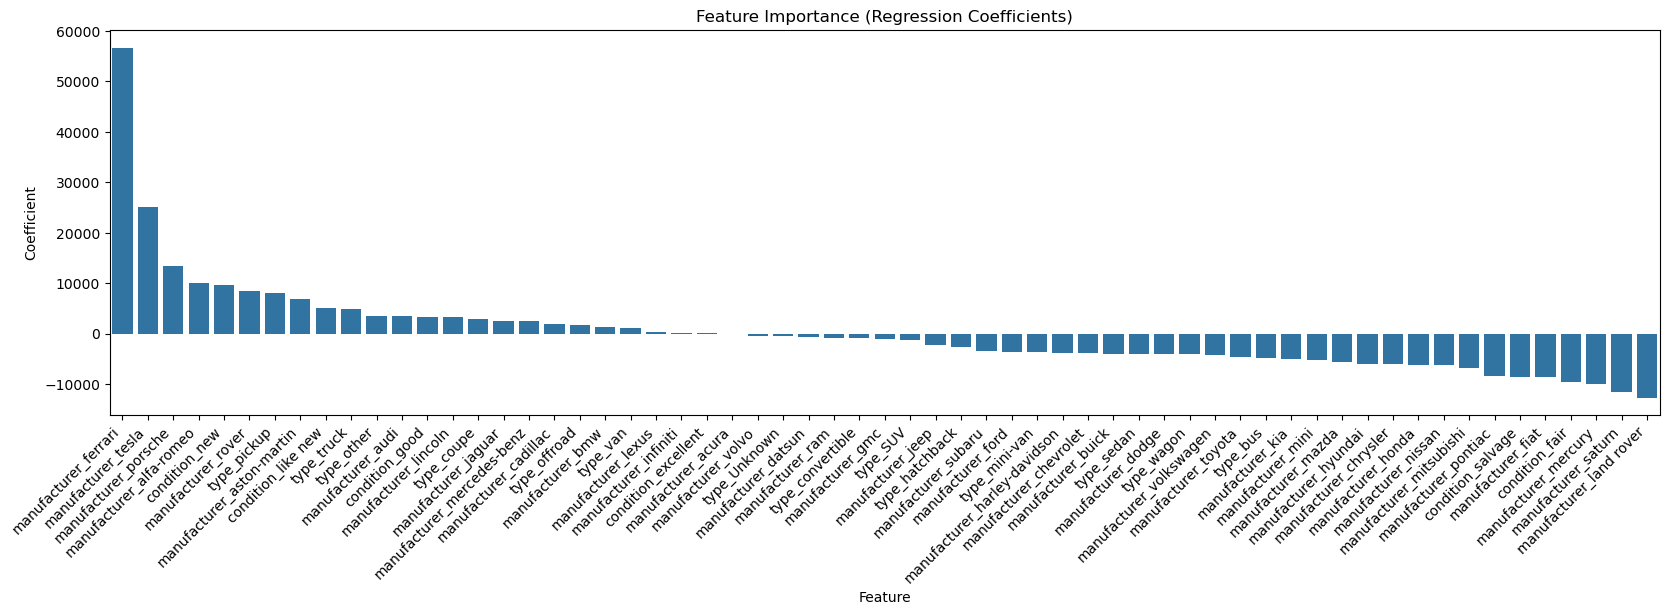

In [165]:


model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

X_selected = X[['condition', 'manufacturer','type']]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
print("MSE:", mse)

# Get names from ColumnTransformer
ohe = model.named_steps['preprocess'].named_transformers_['cat']
encoded_cat_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(numeric_cols) + list(encoded_cat_names)

# Get coefficients
coef = model.named_steps['regressor'].coef_



# Plot

coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coef})
plt.figure(figsize=(20,5))
sns.barplot(y='Coefficient', x='Feature', data=coef_df.sort_values('Coefficient', ascending=False))
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance (Regression Coefficients)")
plt.show()


In [166]:
#Select what features could be important

X = df.drop(columns=['price'])

X_numeric = X.select_dtypes(include=['int64', 'float64'])

y = df['price']

# Split into train and test sets from only numeric columns
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_numeric.columns)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('select', SelectKBest(score_func=f_regression, k=3)),  # pick top 2 features
    ('regressor', LinearRegression())
])

# Fit
model.fit(X_train, y_train)

# Evaluate
print("Test R^2:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
print("MSE:", mse)

# Inspect selected features
feature_names = model.named_steps['preprocess'].get_feature_names_out()
selected = feature_names[model.named_steps['select'].get_support()]
print("Selected features:", selected)


Test R^2: 0.048549418963532154
MSE: 173108060.31958148
Selected features: ['num__id' 'num__year' 'num__odometer']


In [122]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

print('starting the process')
df = pd.read_csv("data/vehicles.csv")

results = {}

for region, group in df.groupby('region'):
    group = group.dropna(subset=['price'])
    X = group.drop(columns=['price', 'id', 'VIN', 'region'])
    y = group['price']

    if len(group) < 50:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Identify column types inside the loop
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('regressor', LinearRegression())
    ])

    model.fit(X_train, y_train)

    # Transform X_test manually
    X_test_transformed = model.named_steps['preprocess'].transform(X_test).toarray()

    # Run permutation importance on regressor only
    result = permutation_importance(
        model.named_steps['regressor'],
        X_test_transformed,
        y_test,
        n_repeats=10,
        random_state=42
    )

    # Extract transformed feature names
    feature_names = model.named_steps['preprocess'].get_feature_names_out()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': result.importances_mean
    }).sort_values('Importance', ascending=False)

    results[region] = importance_df.head(3)

# Display results
for region, top_features in results.items():
    print(f"\nRegion: {region}")
    print(top_features)

starting the process
Features: 1452
Importances: 1452
Features: 167
Importances: 167
Features: 870
Importances: 870
Features: 1041
Importances: 1041
Features: 1513
Importances: 1513
Features: 293
Importances: 293
Features: 286
Importances: 286
Features: 166
Importances: 166
Features: 832
Importances: 832
Features: 591
Importances: 591
Features: 276
Importances: 276
Features: 659
Importances: 659
Features: 778
Importances: 778
Features: 229
Importances: 229
Features: 387
Importances: 387
Features: 1332
Importances: 1332
Features: 164
Importances: 164
Features: 369
Importances: 369
Features: 1307
Importances: 1307
Features: 1107
Importances: 1107
Features: 1151
Importances: 1151
Features: 413
Importances: 413
Features: 326
Importances: 326
Features: 259
Importances: 259
Features: 865
Importances: 865
Features: 237
Importances: 237
Features: 967
Importances: 967
Features: 557
Importances: 557
Features: 376
Importances: 376
Features: 753
Importances: 753
Features: 119
Importances: 119
Feat

C:\Users\ramya\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['size']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
C:\Users\ramya\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['size']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Features: 141
Importances: 141
Features: 159
Importances: 159
Features: 717
Importances: 717
Features: 268
Importances: 268
Features: 116
Importances: 116
Features: 211
Importances: 211
Features: 1112
Importances: 1112
Features: 299
Importances: 299
Features: 931
Importances: 931
Features: 114
Importances: 114
Features: 1427
Importances: 1427
Features: 362
Importances: 362
Features: 1134
Importances: 1134
Features: 146
Importances: 146
Features: 157
Importances: 157
Features: 811
Importances: 811
Features: 255
Importances: 255
Features: 234
Importances: 234
Features: 435
Importances: 435
Features: 333
Importances: 333
Features: 1074
Importances: 1074
Features: 1427
Importances: 1427
Features: 90
Importances: 90
Features: 1317
Importances: 1317
Features: 195
Importances: 195
Features: 381
Importances: 381
Features: 266
Importances: 266
Features: 1603
Importances: 1603
Features: 131
Importances: 131
Features: 505
Importances: 505
Features: 115
Importances: 115
Features: 461
Importances: 

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

starting the process


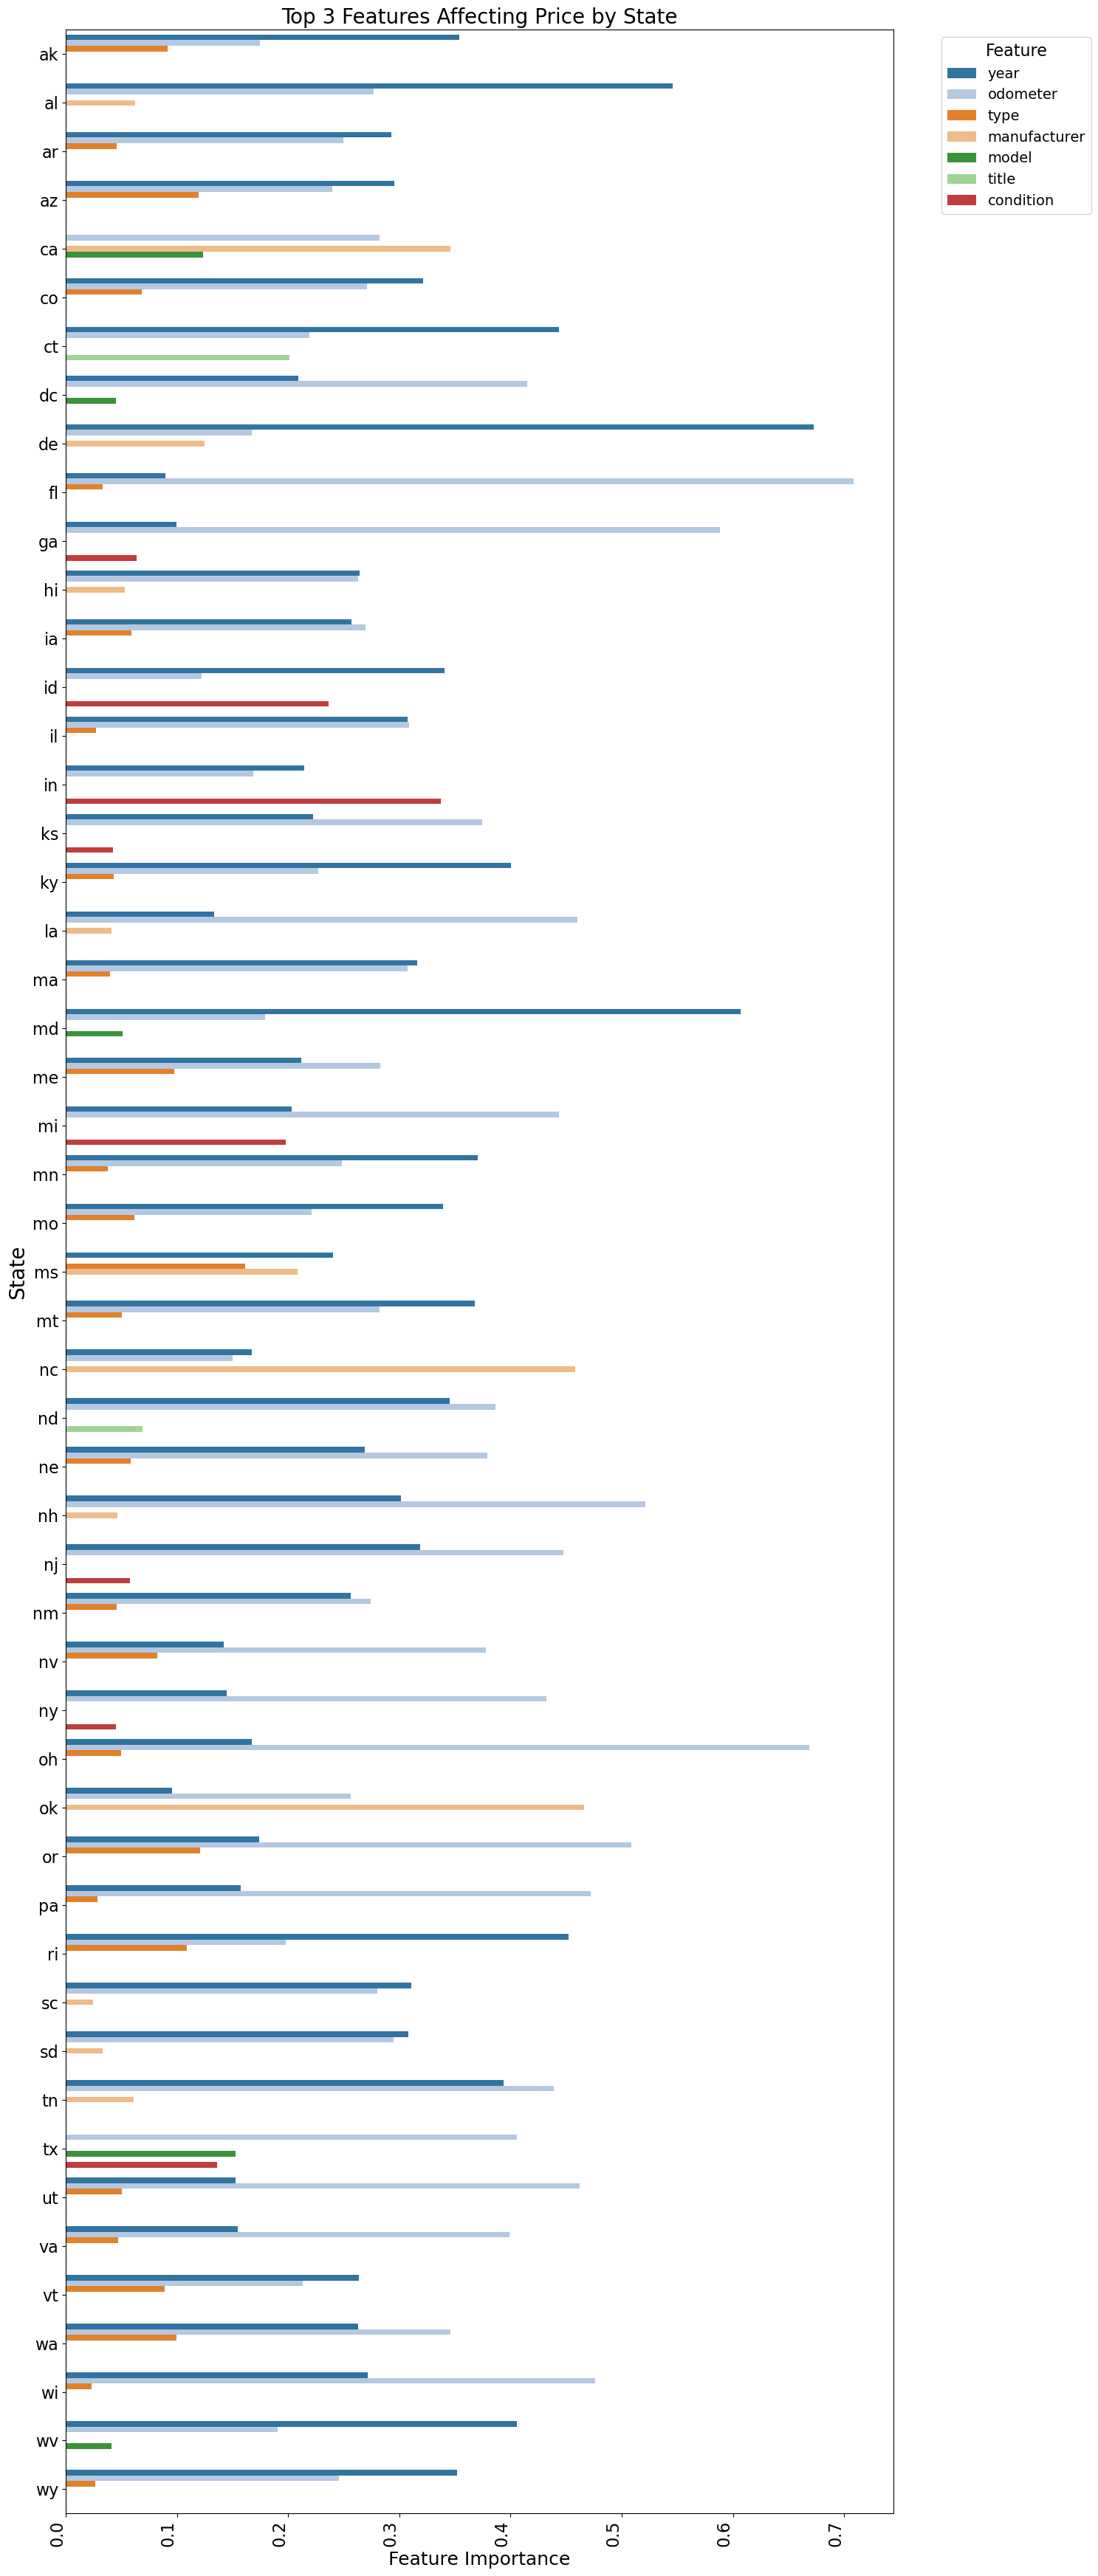

Most common feature across states: [('odometer', 50), ('year', 49), ('type', 27), ('manufacturer', 12), ('condition', 8)]


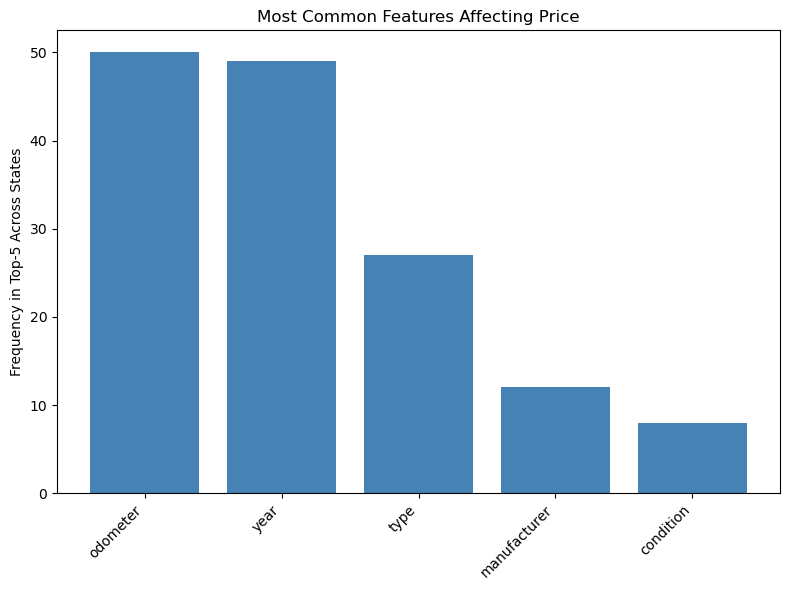

In [8]:
######################################################
########### TOP 3 features by region ##################

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from collections import Counter

def clean_feature_name(name: str) -> str:
    if name.startswith("num__"):
        return name.replace("num__", "", 1)
    if name.startswith("cat__"):
        # remove 'cat__' then split on first underscore
        remainder = name.replace("cat__", "", 1)
        return remainder.split("_", 1)[0]   # keep only base column name
    return name

print('starting the process')
df = pd.read_csv("data/vehicles.csv")

all_results = []

#Loop through all the states and identify top 3 features
for state, group in df.groupby('state'):
    group = group.dropna(subset=['price'])
    X = group.drop(columns=['price', 'fuel', 'id', 'VIN', 'state', 'region', 'cylinders','fuel','size','paint_color','drive', 'transmission'])
    y = group['price']

    if len(group) < 50:
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=50))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1))
    ])

    model.fit(X_train, y_train)

    importances = model.named_steps['regressor'].feature_importances_
    feature_names = model.named_steps['preprocess'].get_feature_names_out()
    clean_names = [clean_feature_name(f) for f in feature_names]


    importance_df = pd.DataFrame({
        'Feature': clean_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(3)

    importance_df['State'] = state
    all_results.append(importance_df)

# Combine all states into one DataFrame
combined_df = pd.concat(all_results)

plt.figure(figsize=(15,35))
sns.barplot(data=combined_df, y="State", x="Importance", hue="Feature", palette="tab20")

# Make x-axis labels bigger
plt.xticks(rotation=90, ha='right', fontsize=16)

# Make y-axis labels bigger
plt.yticks(fontsize=16)

# Axis labels and title with larger font
plt.xlabel("Feature Importance", fontsize=18)
plt.ylabel("State", fontsize=20)
plt.title("Top 3 Features Affecting Price by State", fontsize=20)

# Legend with larger font
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.savefig("top_features_by_state.png", dpi=300)
plt.show()

# Flatten all top features across states
all_top_features = []
for top_features in all_results:
    all_top_features.extend(top_features['Feature'].tolist())

# Count frequencies
feature_counts = Counter(all_top_features)

# Most common feature(s)
most_common_features = feature_counts.most_common(5)
print("Most common feature across states:", most_common_features)

# Convert to DataFrame
counts_df = pd.DataFrame(most_common_features, columns=['Feature','Count'])
counts_df = counts_df.sort_values('Count', ascending=False)

# --- Plot only the most common features ---
plt.figure(figsize=(8,6))
plt.bar(counts_df['Feature'], counts_df['Count'], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Frequency in Top-5 Across States")
plt.title("Most Common Features Affecting Price")
plt.tight_layout()
plt.show()




### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.